## Dogs v Cats

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
import skimage

In [2]:
PATH = "/src/data/dogscats/dogscats"
sz = 224
arch = resnet34
bs = 64

import os
os.listdir(PATH)

['models', 'sample', 'test1', 'tmp', 'train', 'valid']

In [3]:
m = arch(True)

In [4]:
m

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [5]:
m = nn.Sequential(*children(m)[:-2], 
                  nn.Conv2d(512, 2, 3, padding=1), 
                  nn.AdaptiveAvgPool2d(1), Flatten(), 
                  nn.LogSoftmax())

In [255]:
?tfms_from_stats

In [6]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)

In [7]:
learn = ConvLearner.from_model_data(m, data)

In [8]:
learn.freeze_to(-4)

In [9]:
m[-1].trainable

True

In [10]:
m[-4].trainable

True

In [11]:
m[-5].trainable

False

In [12]:
learn.fit(0.01, 1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.207178   0.131749   0.9885    



[0.13174933325871827, 0.9885]

In [13]:
learn.fit(0.01, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.097715   0.106804   0.99      



[0.10680362809449434, 0.99]

In [14]:
learn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

## Class Activation Maps (CAM)

In [15]:
class SaveFeatures():
    '''
    Custom Save Features Class - duh
    '''
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [152]:
x2,y2 = next(iter(data.val_dl))


In [153]:
#??data.val_dl
x2

tensor([[[[ 1.6153e+00,  1.6267e+00,  1.6438e+00,  ..., -1.3707e+00,
           -1.2756e+00, -1.2820e+00],
          [ 1.6172e+00,  1.6299e+00,  1.6616e+00,  ..., -1.4279e+00,
           -1.3461e+00, -1.3372e+00],
          [ 1.6324e+00,  1.6553e+00,  1.6667e+00,  ..., -1.5218e+00,
           -1.4590e+00, -1.4578e+00],
          ...,
          [-8.0827e-01, -1.0478e+00, -1.0832e+00,  ..., -1.9467e+00,
           -1.9169e+00, -1.8992e+00],
          [-1.3552e+00, -1.5315e+00, -1.4187e+00,  ..., -1.9251e+00,
           -1.8813e+00, -1.8483e+00],
          [-1.6458e+00, -1.5406e+00, -1.3879e+00,  ..., -1.8325e+00,
           -1.7830e+00, -1.7145e+00]],

         [[ 1.4540e+00,  1.4540e+00,  1.4540e+00,  ...,  7.5182e-01,
            7.3098e-01,  6.7262e-01],
          [ 1.4534e+00,  1.4534e+00,  1.4449e+00,  ...,  7.3102e-01,
            7.3362e-01,  6.8434e-01],
          [ 1.4482e+00,  1.4482e+00,  1.4423e+00,  ...,  7.1028e-01,
            7.0767e-01,  6.6620e-01],
          ...,
     

In [154]:
x2,y2 = x2[None,1], y2[None,1]
vx = Variable(x2.cuda(), requires_grad=True)

In [155]:
m

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

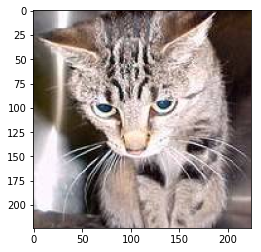

In [169]:
dx = data.val_ds.denorm(x2)
dx = dx[0]
plt.imshow(dx)

In [170]:
dx

array([[[0.42951, 0.41794, 0.42187],
        [0.43399, 0.42242, 0.42634],
        [0.44032, 0.42875, 0.43267],
        ...,
        [0.18095, 0.11316, 0.06495],
        [0.18827, 0.1214 , 0.06836],
        [0.19568, 0.12882, 0.07578]],

       [[0.43355, 0.42571, 0.42963],
        [0.43861, 0.43076, 0.43469],
        [0.44475, 0.4369 , 0.44082],
        ...,
        [0.17148, 0.10198, 0.04662],
        [0.17834, 0.10884, 0.04958],
        [0.18715, 0.11765, 0.05839]],

       [[0.43922, 0.43137, 0.43529],
        [0.44215, 0.43431, 0.43823],
        [0.44893, 0.44108, 0.44501],
        ...,
        [0.1696 , 0.10299, 0.03589],
        [0.17646, 0.10991, 0.03873],
        [0.18526, 0.11872, 0.04753]],

       ...,

       [[0.43203, 0.36688, 0.34684],
        [0.4211 , 0.35808, 0.33167],
        [0.41656, 0.35285, 0.32853],
        ...,
        [0.45381, 0.3793 , 0.38715],
        [0.45381, 0.3793 , 0.38715],
        [0.45381, 0.3793 , 0.38715]],

       [[0.44833, 0.37401, 0.36391],
  

In [171]:
sfs = [SaveFeatures(o) for o in [m[-7], m[-6], m[-5], m[-4]]]

In [172]:
m[-4]

Conv2d(512, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [173]:
sfs[0].features

In [174]:
%time py = m(Variable(x.cuda()))

Wall time: 12 ms


In [175]:
for o in sfs: o.remove()

In [176]:
[o.features.size() for o in sfs]

[torch.Size([1, 128, 28, 28]),
 torch.Size([1, 256, 14, 14]),
 torch.Size([1, 512, 7, 7]),
 torch.Size([1, 2, 7, 7])]

In [177]:
py = np.exp(to_np(py)[0]); py

array([1., 0.], dtype=float32)

In [239]:
feat = np.maximum(0,to_np(sfs[3].features[0]))
feat.shape

(2, 7, 7)

In [240]:
f2=np.dot(np.rollaxis(feat,0,3), py)
f2


array([[27.55494, 39.46859, 39.7856 , 36.63998, 34.8027 , 30.30743, 18.6576 ],
       [38.58298, 56.93545, 60.0108 , 57.03769, 56.61997, 49.86317, 30.45098],
       [39.58378, 61.1045 , 67.70815, 67.4744 , 69.96329, 63.31456, 39.82455],
       [37.05197, 58.74424, 68.81008, 71.54906, 75.47218, 69.69159, 45.55502],
       [34.90163, 55.29257, 64.17142, 64.19238, 68.94151, 65.70556, 44.15808],
       [27.90146, 44.15351, 50.04641, 47.75785, 50.26436, 49.03651, 34.00778],
       [14.48585, 22.91603, 24.70611, 21.55622, 21.59521, 21.9947 , 15.73048]], dtype=float32)

In [241]:
f2-=f2.min()
f2/=f2.max()
f2

array([[0.2143 , 0.40964, 0.41484, 0.36326, 0.33314, 0.25943, 0.0684 ],
       [0.39512, 0.69605, 0.74648, 0.69773, 0.69088, 0.58009, 0.26178],
       [0.41153, 0.76441, 0.87269, 0.86886, 0.90967, 0.80065, 0.41548],
       [0.37002, 0.72571, 0.89076, 0.93567, 1.     , 0.90521, 0.50944],
       [0.33476, 0.66911, 0.8147 , 0.81504, 0.89292, 0.83986, 0.48654],
       [0.21998, 0.48646, 0.58309, 0.54556, 0.58666, 0.56653, 0.3201 ],
       [0.     , 0.13823, 0.16758, 0.11593, 0.11657, 0.12312, 0.02041]], dtype=float32)

In [242]:
f2[f2 > 0.5] = 1
f2[f2 < 0.5] = 0

f2

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 0.],
       [0., 1., 1., 1., 1., 1., 0.],
       [0., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 0.],
       [0., 0., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [252]:
f3 = np.ma.masked_equal(f2,1)

array([0, 1, 1, 1, 1, 2, 0], dtype=int64)

C:\Users\amunchet\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\amunchet\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


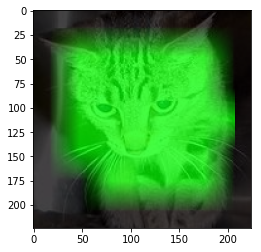

In [244]:
plt.imshow(dx)
import skimage.transform as tf
#tf
plt.imshow(tf.resize(f2, dx.shape), alpha=0.74, cmap='jet');

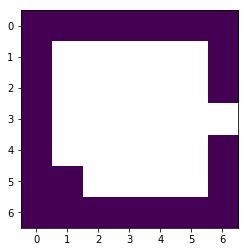

In [245]:
#tf.resize(f2,dx.shape)
f3.shape
plt.imshow(f3)

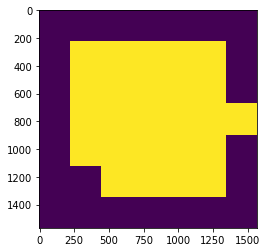

In [214]:
f3 = np.kron(f2, np.ones((224,224)))
plt.imshow(f3)

## Model

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
# 12 layer groups call for 12 lrs
lr=np.array([[1e-6]*4,[1e-4]*4,[1e-2]*4]).flatten()

In [ ]:
learn.fit(lr, 2, cycle_len=1)

A Jupyter Widget

[ 0.       0.02049  0.01577  0.99405]                         
[ 1.       0.01648  0.0137   0.99554]                          



In [ ]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)
accuracy_np(preds,y)

0.996

In [ ]:
learn.fit(lr, 2, cycle_len=1)

A Jupyter Widget

[ 0.       0.01243  0.01535  0.99554]                          
[ 1.       0.0128   0.01507  0.99554]                          



In [ ]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)
accuracy_np(preds,y)

0.99650000000000005